In [8]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM, AblationCAM, ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [15]:
# Set up the model and device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the pretrained ResNet50 model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
model.eval()

# The last convolutional layer in ResNet50 is 'layer4'. We'll use its last block.
target_layers = [model.layer4[-1]]

Using device: cpu


In [16]:
# Direct URLs to the 10 images
image_urls = [
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02098286_West_Highland_white_terrier.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02018207_American_coot.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04037443_racer.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02007558_flamingo.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01608432_kite.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01443537_goldfish.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01491361_tiger_shark.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01616318_vulture.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01677366_common_iguana.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07747607_orange.JPEG"
]

# Standard ImageNet preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def download_and_process_image(url):
    """Downloads an image, processes it for the model, and returns tensors."""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")

    # Preprocess for the model
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    # Create a normalized version for visualization
    # Convert image to numpy array and scale to 0-1 range for plotting
    rgb_img = np.array(img.resize((224, 224)), dtype=np.float32) / 255.0

    return input_tensor, rgb_img

100%|██████████| 128/128 [03:33<00:00,  1.67s/it]


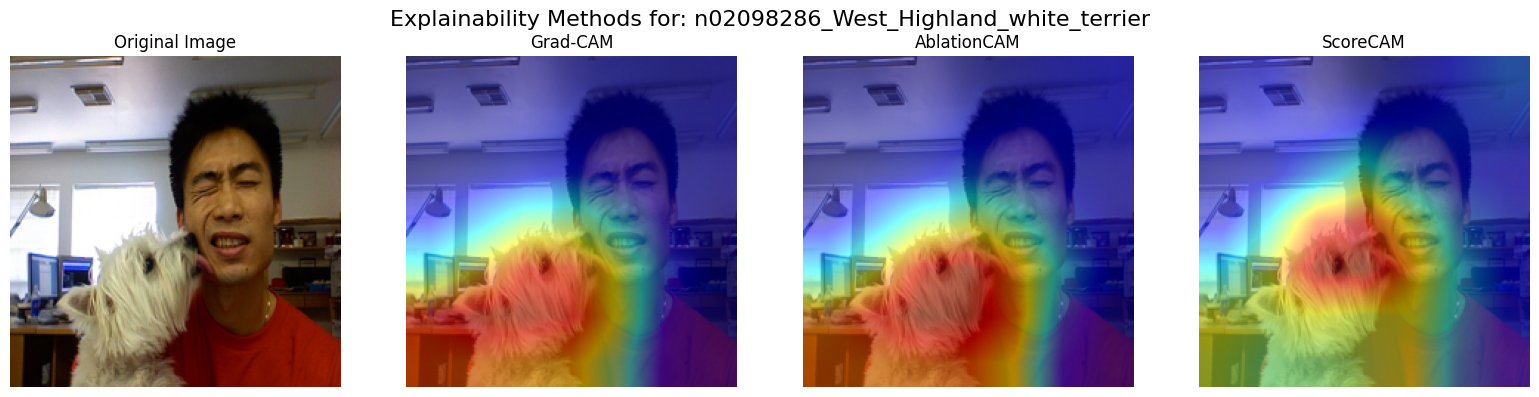

100%|██████████| 128/128 [21:10<00:00,  9.93s/it]  


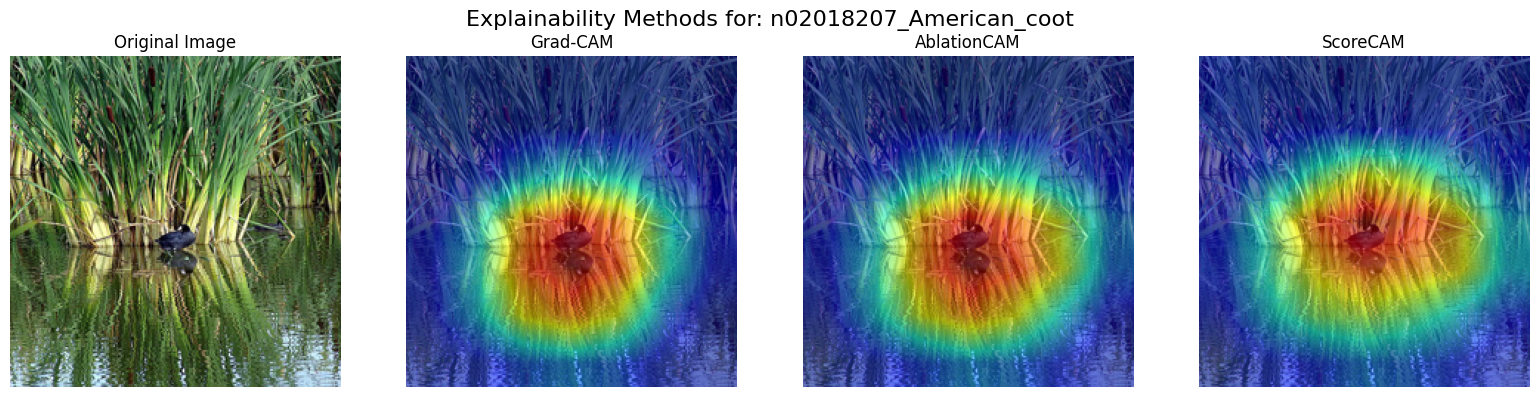

100%|██████████| 128/128 [03:34<00:00,  1.68s/it]


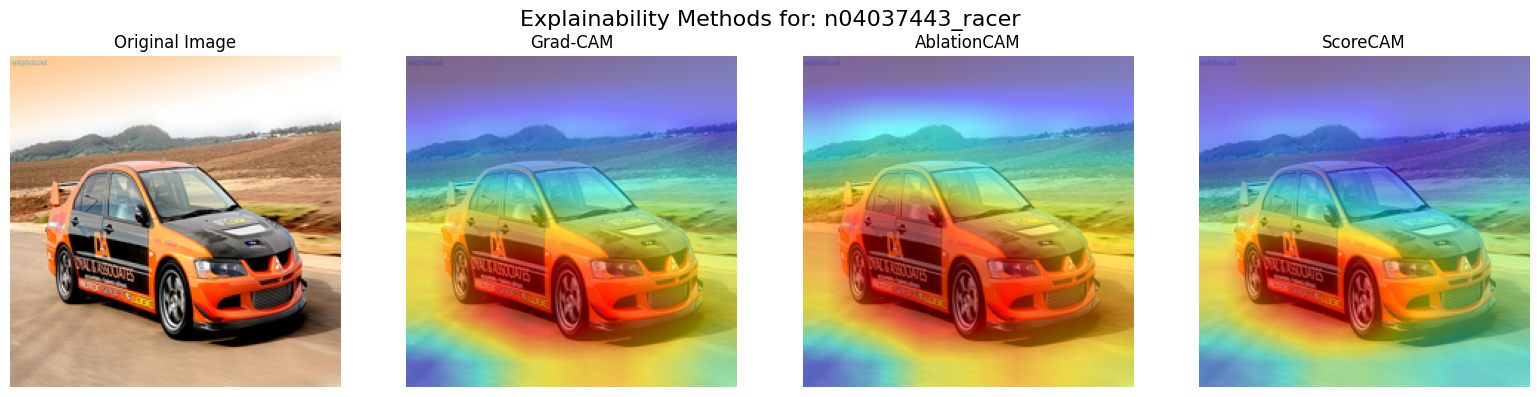

100%|██████████| 128/128 [03:32<00:00,  1.66s/it]


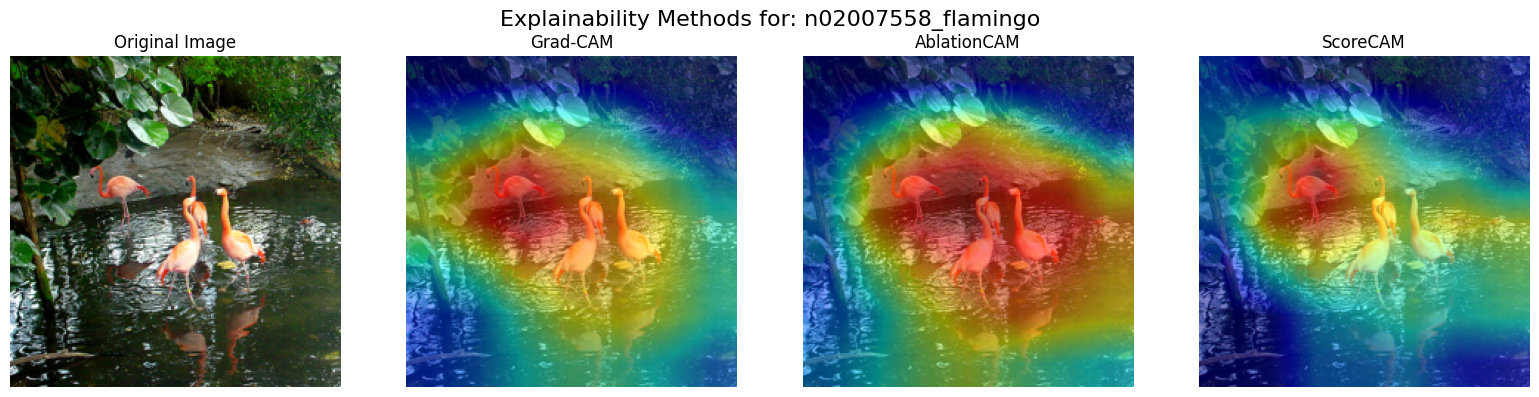

100%|██████████| 128/128 [03:33<00:00,  1.67s/it]


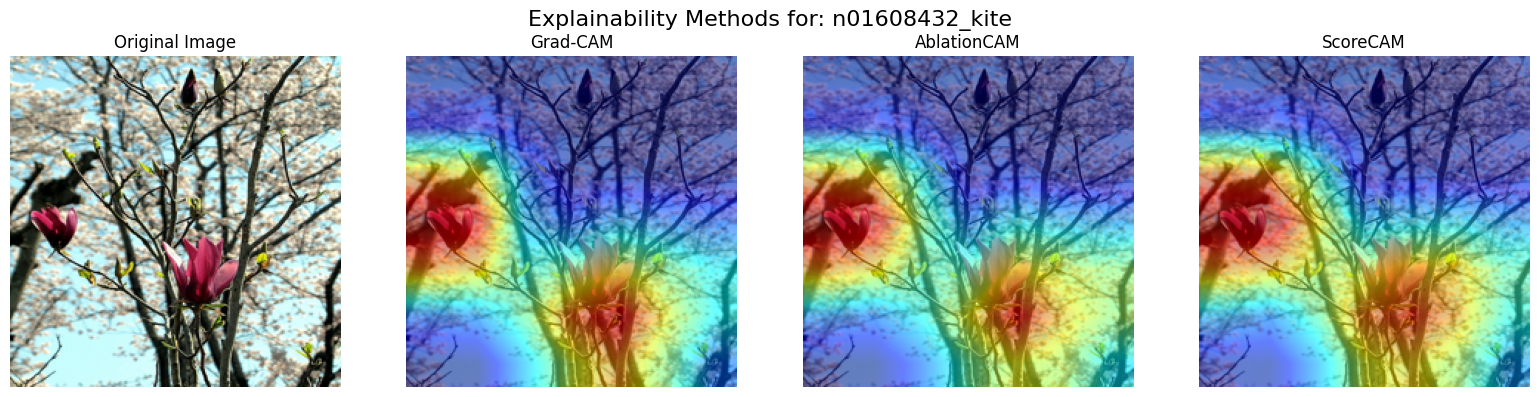

100%|██████████| 128/128 [03:36<00:00,  1.69s/it]


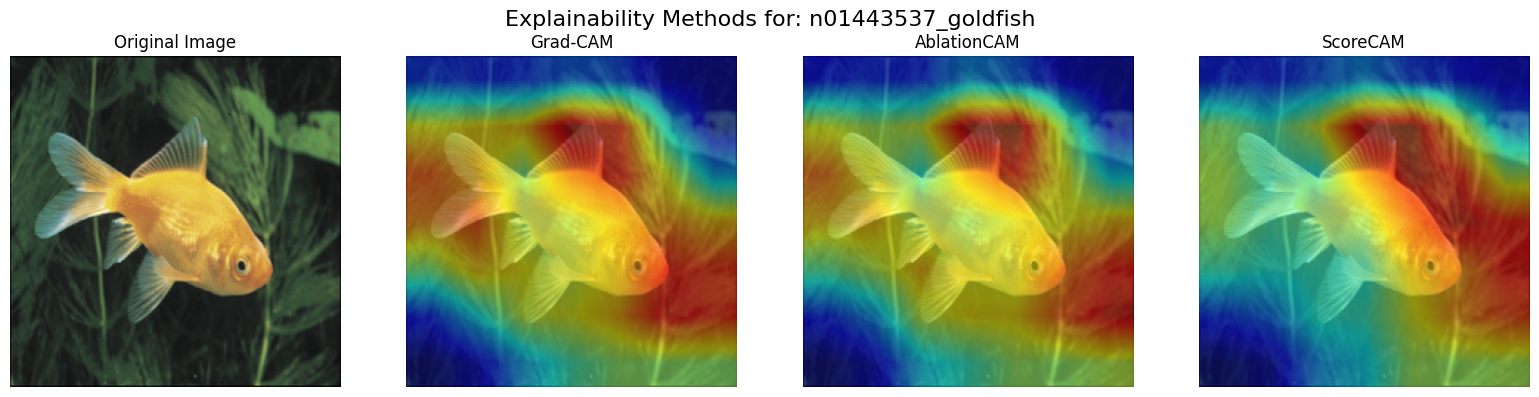

100%|██████████| 128/128 [03:33<00:00,  1.67s/it]


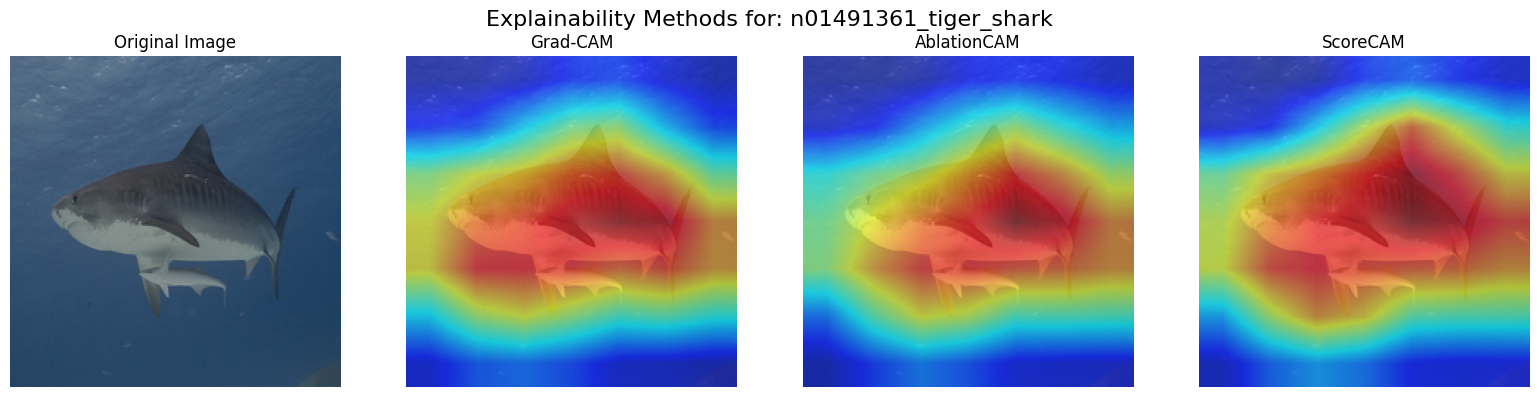

100%|██████████| 128/128 [03:39<00:00,  1.71s/it]


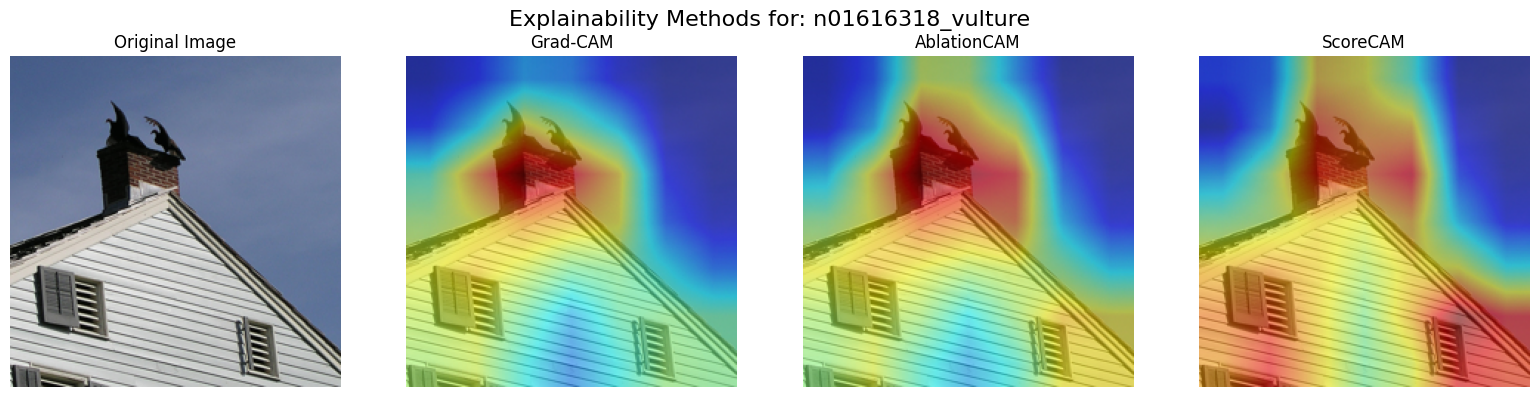

100%|██████████| 128/128 [03:35<00:00,  1.68s/it]


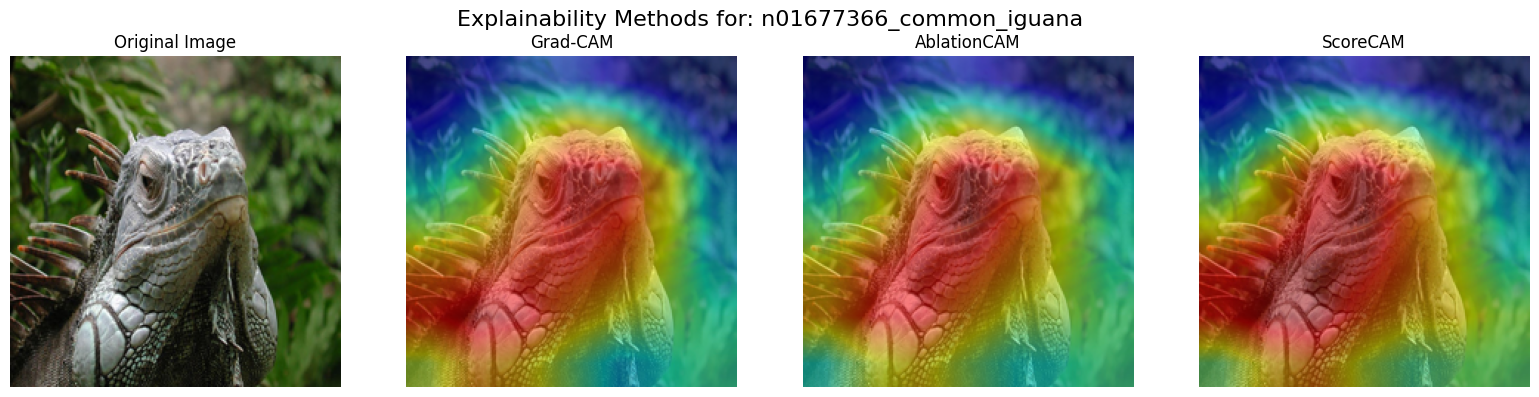

100%|██████████| 128/128 [03:39<00:00,  1.71s/it]


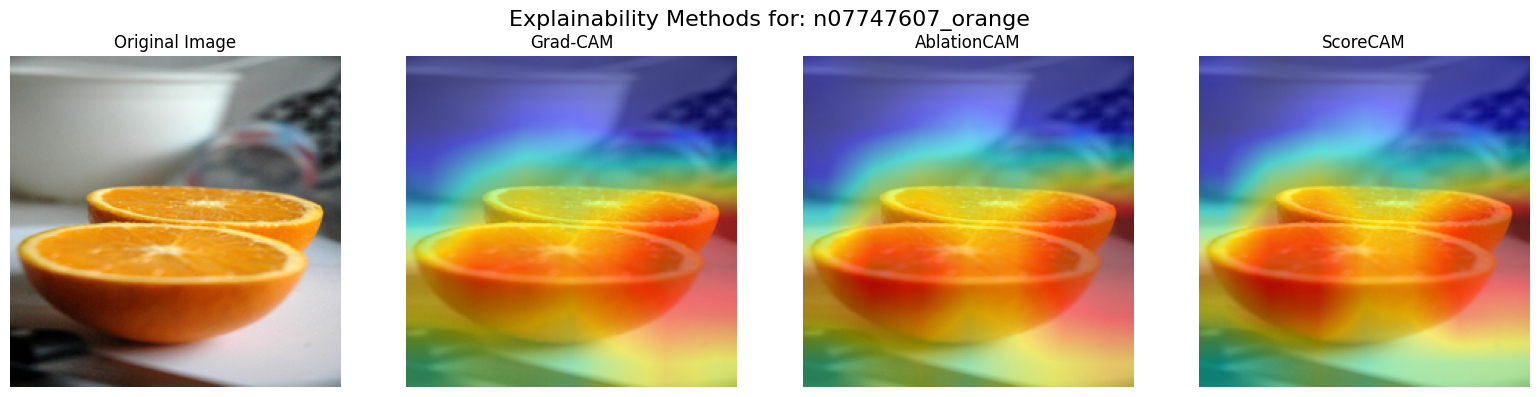

In [17]:
# Instantiate the CAM models once
grad_cam = GradCAM(model=model, target_layers=target_layers)
ablation_cam = AblationCAM(model=model, target_layers=target_layers)
score_cam = ScoreCAM(model=model, target_layers=target_layers)

# Loop over each image URL
for url in image_urls:
    input_tensor, rgb_img = download_and_process_image(url)

    # Get the model's prediction for the image
    output = model(input_tensor)
    top_prediction_index = output.argmax()

    # Define the target for the CAMs
    targets = [ClassifierOutputTarget(top_prediction_index)]

    # Generate CAMs
    grayscale_grad_cam = grad_cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)
    grayscale_ablation_cam = ablation_cam(input_tensor=input_tensor, targets=targets)
    grayscale_score_cam = score_cam(input_tensor=input_tensor, targets=targets)

    # Combine CAMs with original images for visualization
    grad_cam_viz = show_cam_on_image(rgb_img, grayscale_grad_cam[0, :], use_rgb=True)
    ablation_cam_viz = show_cam_on_image(rgb_img, grayscale_ablation_cam[0, :], use_rgb=True)
    score_cam_viz = show_cam_on_image(rgb_img, grayscale_score_cam[0, :], use_rgb=True)

    # --- Plot the results ---
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    image_name = url.split('/')[-1].split('.')[0]
    fig.suptitle(f'Explainability Methods for: {image_name}', fontsize=16)

    axes[0].imshow(rgb_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(grad_cam_viz)
    axes[1].set_title('Grad-CAM')
    axes[1].axis('off')

    axes[2].imshow(ablation_cam_viz)
    axes[2].set_title('AblationCAM')
    axes[2].axis('off')

    axes[3].imshow(score_cam_viz)
    axes[3].set_title('ScoreCAM')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()